In [55]:
import os
import allel
import zarr
import pandas as pd
import petl as etl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
#import pyfasta
import dask
# quieten dask warnings about large chunks
dask.config.set(**{'array.slicing.split_large_chunks': True})
import malariagen_data
ag3 = malariagen_data.Ag3("gs://vo_agam_release/")

-----------------------------------------
## Admixture statistics

In [56]:
calldata_out= zarr.open('/media/randomx/Volume/Ag1000G/Phase3/Data/Extras/outgroup_alleles_phase3.zarr')
calldata_out

<zarr.hierarchy.Group '/'>

In [57]:
calldata_biallel= zarr.open('/media/randomx/Volume/Ag1000G/Phase3/Data/Extras/fw_biallelic_count_pca_pops.zarr/')

In [58]:
metadata = pd.read_csv('../Data/Meta/west_africa_phase3_n2.csv')
metadata

,Unnamed: 0,sample_id,partner_sample_id,contributor,country,location,year,month,longitude,latitude,...,aim_fraction_arab,species_gambcolu_arabiensis,species_gambiae_coluzzii,species,locspe,population,2La_type,2Rd_type,pca_pops,pca_country
0,0,AB0085-Cx,BF2-4,Austin Burt,Burkina Faso,Pala,2012,7,-4.235,11.150,...,2.0,gamb_colu,gambiae,gambiae,2012_Burkina Faso_Pala_gambiae,SBF1_12,2La_alt,2Rd_hom,An.gam,BFgam
1,1,AB0086-Cx,BF2-6,Austin Burt,Burkina Faso,Pala,2012,7,-4.235,11.150,...,2.0,gamb_colu,gambiae,gambiae,2012_Burkina Faso_Pala_gambiae,SBF1_12,2La_alt,2Rd_hom,An.gam,BFgam
2,2,AB0087-C,BF3-3,Austin Burt,Burkina Faso,Bana,2012,7,-4.472,11.233,...,2.0,gamb_colu,coluzzii,coluzzii,2012_Burkina Faso_Bana_coluzzii,MBF2_12,2La_alt,2Rd_hom,An.col,BFcol
3,3,AB0088-C,BF3-5,Austin Burt,Burkina Faso,Bana,2012,7,-4.472,11.233,...,2.0,gamb_colu,coluzzii,coluzzii,2012_Burkina Faso_Bana_coluzzii,MBF2_12,2La_alt,2Rd_hom,An.col,BFcol
4,4,AB0089-Cx,BF3-8,Austin Burt,Burkina Faso,Bana,2012,7,-4.472,11.233,...,2.0,gamb_colu,coluzzii,coluzzii,2012_Burkina Faso_Bana_coluzzii,MBF2_12,2La_alt,2Rd_hom,An.col,BFcol
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185,1185,AJ0060-C,BIS038,Joao Pinto,Guinea-Bissau,Antula,2010,-1,-15.582,11.891,...,6.0,gamb_colu,intermediate,intermediate_gambiae_coluzzii,2010_Guinea-Bissau_Antula_intermediate_gambiae...,FW2,2La_hom,2Rd_hom,GW,GW-1
1186,1186,AJ0068-C,BIS046,Joao Pinto,Guinea-Bissau,Antula,2010,-1,-15.582,11.891,...,6.0,gamb_colu,intermediate,intermediate_gambiae_coluzzii,2010_Guinea-Bissau_Antula_intermediate_gambiae...,FW2,2La_het,2Rd_hom,GW,GW-1
1187,1187,AJ0080-C,BIS058,Joao Pinto,Guinea-Bissau,Antula,2010,-1,-15.582,11.891,...,5.0,gamb_colu,intermediate,intermediate_gambiae_coluzzii,2010_Guinea-Bissau_Antula_intermediate_gambiae...,FW2,2La_het,2Rd_hom,GW,GW-1
1188,1188,AJ0087-C,BIS065,Joao Pinto,Guinea-Bissau,Antula,2010,-1,-15.582,11.891,...,6.0,gamb_colu,intermediate,intermediate_gambiae_coluzzii,2010_Guinea-Bissau_Antula_intermediate_gambiae...,FW2,2La_het,2Rd_hom,GW,GW-1


In [59]:
ac_cache = dict()

def load_ac(chrom, pop):
    if (chrom, pop) in ac_cache:
        return ac_cache[chrom, pop]
    else:
        if pop in out_species:
            ac = calldata_out[chrom][pop][:,:2]
        else:
            ac = calldata_biallel[chrom][pop]
            ac_cache[chrom, pop] = ac
        return ac

In [60]:
fourpop_cache = dict()

In [61]:
chromosomes = ['3L', '3R']
out_species = ['chri', 'epir']

In [62]:
an_col = 'An.col'
an_gam = 'An.gam'
an_na = 'GM-1', 'GM-2', 'GW'

----------------------------------------------
## ABBA BABA TEST WITH <i> An. christyi </i>

In [46]:
def f4_analysis(chroms, A, B, C, D, regions=None, blen=100000, plot=False, ax=None):
    
    
    
    region_str = ",".join(["{0}_{1}".format(r.start, r.stop) for r in regions])
    
    key = (",".join(chroms), region_str, A, B, C, D, blen)
    if key in fourpop_cache:
        # re-use from cache
        d, d_se, d_z, d_vb, d_vj = fourpop_cache[key]
        
    else:
        # load allele counts
        aca = dask.array.vstack([load_ac(chrom, A)[region] for chrom, region in zip(chroms, regions)])
        acb = dask.array.vstack([load_ac(chrom, B)[region] for chrom, region in zip(chroms, regions)])
        acc = dask.array.vstack([load_ac(chrom, C)[region] for chrom, region in zip(chroms, regions)])
        acd = dask.array.vstack([load_ac(chrom, D)[region] for chrom, region in zip(chroms, regions)])
            
        # run D test
        d, d_se, d_z, d_vb, d_vj = allel.blockwise_patterson_d(aca, acb, acc, acd, 
                                                                     blen=blen)
        
        # cache for re-use
        fourpop_cache[key] = d, d_se, d_z, d_vb, d_vj
    
    return d, d_se, d_z, d_vb, d_vj

def f4_analys(As, Bs, Cs, Ds, chroms=chromosomes, regions=None, blen=100000):
    
    if regions is None:
        regions = [slice(None)] * 4
    
    region_str = ",".join(["{0}_{1}".format(r.start, r.stop) for r in regions])
    # normalise inputs
    if not isinstance(chroms, (list, tuple)):
        chroms = [chroms]
    if not isinstance(As, (list, tuple)):
        As = [As]
    if not isinstance(Bs, (list, tuple)):
        Bs = [Bs]
    if not isinstance(Cs, (list, tuple)):
        Cs = [Cs]
    if not isinstance(Ds, (list, tuple)):
        Ds = [Ds]
        
    # setup output table
    tbl = [['chromosome', 'test', 'D', 'SE', 'Z']]

    for A in As:
        for B in Bs:
            if A != B:
                for C in Cs:
                    for D in Ds:
                        if C != D:
                            d, d_se, d_z, _, _ = f4_analysis(chroms, A, B, C, D, 
                                                             regions=regions, blen=blen)
                            test = 'D(%s, %s; %s, %s)' % (A, B, C, D)
                            row = [",".join(chroms), test, d, d_se, d_z]
                            tbl += [row]
    
                        

    # display results
    (etl
     .wrap(tbl)
     .interpolate('D', '%.3f')
     .interpolate('SE', '%.4f')
     .interpolate('Z', '%.1f')
     .displayall(index_header=False, 
                 tr_style=lambda row: 'background-color: %s' % ('#afa' if float(row.Z) > 5 else '#aaf' if float(row.Z) < -5 else 'white')))
    return tbl
    
def tbl_display(tbl):
        # display results
    (etl
     .wrap(tbl)
     .interpolate('D', '%.3f')
     .interpolate('SE', '%.4f')
     .interpolate('Z', '%.1f')
     .displayall(index_header=False, 
                 tr_style=lambda row: 'background-color: %s' % ('#afa' if float(row.Z) > 5 else '#aaf' if float(row.Z) < -5 else 'white')))
    
def tbl_d_plot(table, title):
    # plot
    tbl = etl.wrap(table).sort('test')
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20, 10))
    
    ## First Plot - Bar Plot
    x = tbl.values('D').array()
    y = np.arange(tbl.nrows())
    ax1.axvline(0, color='r', lw=1)
    xerr = tbl.values('SE').array()
    ax1.errorbar(x, y, xerr=xerr, fmt='o', lw=1, color='k', mew=1, mfc='k')
    ax1.set_yticks(y)
    ylbls = ['%s; Z = %.1f' % (v.test, v.Z) for v in tbl.records()]
    ax1.set_yticklabels(ylbls)
    ax1.yaxis.tick_right()
    ax1.xaxis.tick_top()
    ax1.xaxis.set_label_position('top')
    ax1.set_xlim(-.2,.2)
    ax1.set_ylim(-1, y.size)
    ax1.grid(axis='both', color='#dddddd')
    ax1.set_xlabel("Patterson's $D$ Barplot")
    fig.suptitle('%s' % (title), y=1.02, fontsize=16)

    ## Second plot - Heatmap
    results = etl.todataframe(tbl)
    df1 = results[['test', 'D','Z']].round(2)
    heatmap1_data = pd.pivot_table(df1, values='Z', 
                     index=['test'], 
                     columns='D')
    lm = sns.heatmap(heatmap1_data, cmap="RdBu", vmin=15, vmax=-15, annot=True)
    ax2 = lm.axes
    ax2.set_xlim(-.7)
    #ax2.set_ylim(40.4)
    ax2.xaxis.set_label_position('top')
    ax2.xaxis.tick_top()
    plt.xticks(rotation=70)
    ax2.set_xlabel("Patterson's $D$ Heatmap")
    ax2.invert_yaxis()
    plt.text(1.02, 0.5, 'Z-score', {'fontsize': 15},
             horizontalalignment='left',
             verticalalignment='center',
             rotation=90,
             clip_on=False,
             transform=plt.gca().transAxes)

    ax2.grid(False, 'major')
    ax2.grid(True, 'minor')
    ax2.set_yticks([t - 0.5 for t in ax2.get_yticks()], minor=True)
    sns.despine()
    fig.tight_layout()
    plt.show()  

In [47]:
A = an_gam
B = an_na
C = an_col
D = 'chri'

In [48]:
d_col = f4_analys(A, B, C, D, chroms=("3L", "3R"),
                regions=(slice(18_000_000, 41_000_000), slice(1, 24000000)))

chromosome,test,D,SE,Z
"3L,3R","D(An.gam, GM-1; An.col, chri)",-0.052,0.0029,-17.6
"3L,3R","D(An.gam, GM-2; An.col, chri)",-0.027,0.0015,-18.0
"3L,3R","D(An.gam, GW; An.col, chri)",-0.030,0.0017,-18.0


-----------------------------------------
## f3 Statistics

In [63]:
def f4_analysis(chroms, A, B, C, regions=None, blen=100000, plot=False, ax=None):
    
    
    
    region_str = ",".join(["{0}_{1}".format(r.start, r.stop) for r in regions])
    
    key = (",".join(chroms), region_str, A, B, C, blen)
    if key in fourpop_cache:
        # re-use from cache
        d, d_se, d_z, d_vb, d_vj = fourpop_cache[key]
        
    else:
        # load allele counts
        aca = dask.array.vstack([load_ac(chrom, A)[region] for chrom, region in zip(chroms, regions)])
        acb = dask.array.vstack([load_ac(chrom, B)[region] for chrom, region in zip(chroms, regions)])
        acc = dask.array.vstack([load_ac(chrom, C)[region] for chrom, region in zip(chroms, regions)])
            
        # run D test
        d, d_se, d_z, d_vb, d_vj = allel.average_patterson_f3(aca, acb, acc, 
                                                                     blen=blen)
        
        # cache for re-use
        fourpop_cache[key] = d, d_se, d_z, d_vb, d_vj
    
    return d, d_se, d_z, d_vb, d_vj

def f4_analys(As, Bs, Cs, chroms=chromosomes, regions=None, blen=100000):
    
    if regions is None:
        regions = [slice(None)] * 4
    
    region_str = ",".join(["{0}_{1}".format(r.start, r.stop) for r in regions])
    # normalise inputs
    if not isinstance(chroms, (list, tuple)):
        chroms = [chroms]
    if not isinstance(As, (list, tuple)):
        As = [As]
    if not isinstance(Bs, (list, tuple)):
        Bs = [Bs]
    if not isinstance(Cs, (list, tuple)):
        Cs = [Cs]

    # setup output table
    tbl = [['chromosome', 'test', 'f3', 'SE', 'Z']]

    for A in As:
        for B in Bs:
            if A != B:
                for C in Cs:
                        if B != C:
                            d, d_se, d_z, _, _ = f4_analysis(chroms, A, B, C,  
                                                             regions=regions, blen=blen)
                            test = 'f3(%s, %s; %s)' % (A, B, C)
                            row = [",".join(chroms), test, d, d_se, d_z]
                            tbl += [row]

    # display results
    (etl
     .wrap(tbl)
     .interpolate('f3', '%.3f')
     .interpolate('SE', '%.4f')
     .interpolate('Z', '%.1f')
     .displayall(index_header=False, 
                 tr_style=lambda row: 'background-color: %s' % ('#afa' if float(row.Z) > 3 else '#aaf' if float(row.Z) < -3 else 'white')))
    return tbl


def tbl_d_plot(table, title):
    # plot
    tbl = etl.wrap(table).sort('test')
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20, 10))
    
    ## First Plot - Bar Plot
    x = tbl.values('f3').array()
    y = np.arange(tbl.nrows())
    ax1.axvline(0, color='r', lw=1)
    xerr = tbl.values('SE').array()
    ax1.errorbar(x, y, xerr=xerr, fmt='o', lw=1, color='k', mew=1, mfc='k')
    ax1.set_yticks(y)
    ylbls = ['%s; Z = %.1f' % (v.test, v.Z) for v in tbl.records()]
    ax1.set_yticklabels(ylbls)
    ax1.yaxis.tick_right()
    ax1.xaxis.tick_top()
    ax1.xaxis.set_label_position('top')
    ax1.set_xlim(-.2,.2)
    ax1.set_ylim(-1, y.size)
    ax1.grid(axis='both', color='#dddddd')
    ax1.set_xlabel("F3 Statistics Barplot")
    fig.suptitle('%s' % (title), y=1.02, fontsize=16)

    ## Second plot - Heatmap
    results = etl.todataframe(tbl)
    df1 = results[['test', 'f3','Z']].round(2)
    heatmap1_data = pd.pivot_table(df1, values='Z', 
                     index=['test'], 
                     columns='f3')
    lm = sns.heatmap(heatmap1_data, cmap="RdBu", vmin=15, vmax=-15, annot=True)
    ax2 = lm.axes
    ax2.set_xlim(-.7)
    #ax2.set_ylim(40.4)
    ax2.xaxis.set_label_position('top')
    ax2.xaxis.tick_top()
    plt.xticks(rotation=70)
    ax2.set_xlabel("F3 Statistics Heatmap")
    ax2.invert_yaxis()
    plt.text(1.02, 0.5, 'Z-score', {'fontsize': 15},
             horizontalalignment='left',
             verticalalignment='center',
             rotation=90,
             clip_on=False,
             transform=plt.gca().transAxes)

    ax2.grid(False, 'major')
    ax2.grid(True, 'minor')
    ax2.set_yticks([t - 0.5 for t in ax2.get_yticks()], minor=True)
    sns.despine()
    fig.tight_layout()
    plt.show()  

In [65]:
A = an_gam
B = an_col
C = an_na

In [66]:
f3_an = f4_analys(A, B, C, chroms=("3L", "3R"),
                regions=(slice(18_000_000, 41_000_000), slice(1, 24000000)))

chromosome,test,f3,SE,Z
"3L,3R","f3(An.gam, An.col; GM-1)",0.030,0.0017,17.4
"3L,3R","f3(An.gam, An.col; GM-2)",0.018,0.0008,22.5
"3L,3R","f3(An.gam, An.col; GW)",0.021,0.0010,21.4


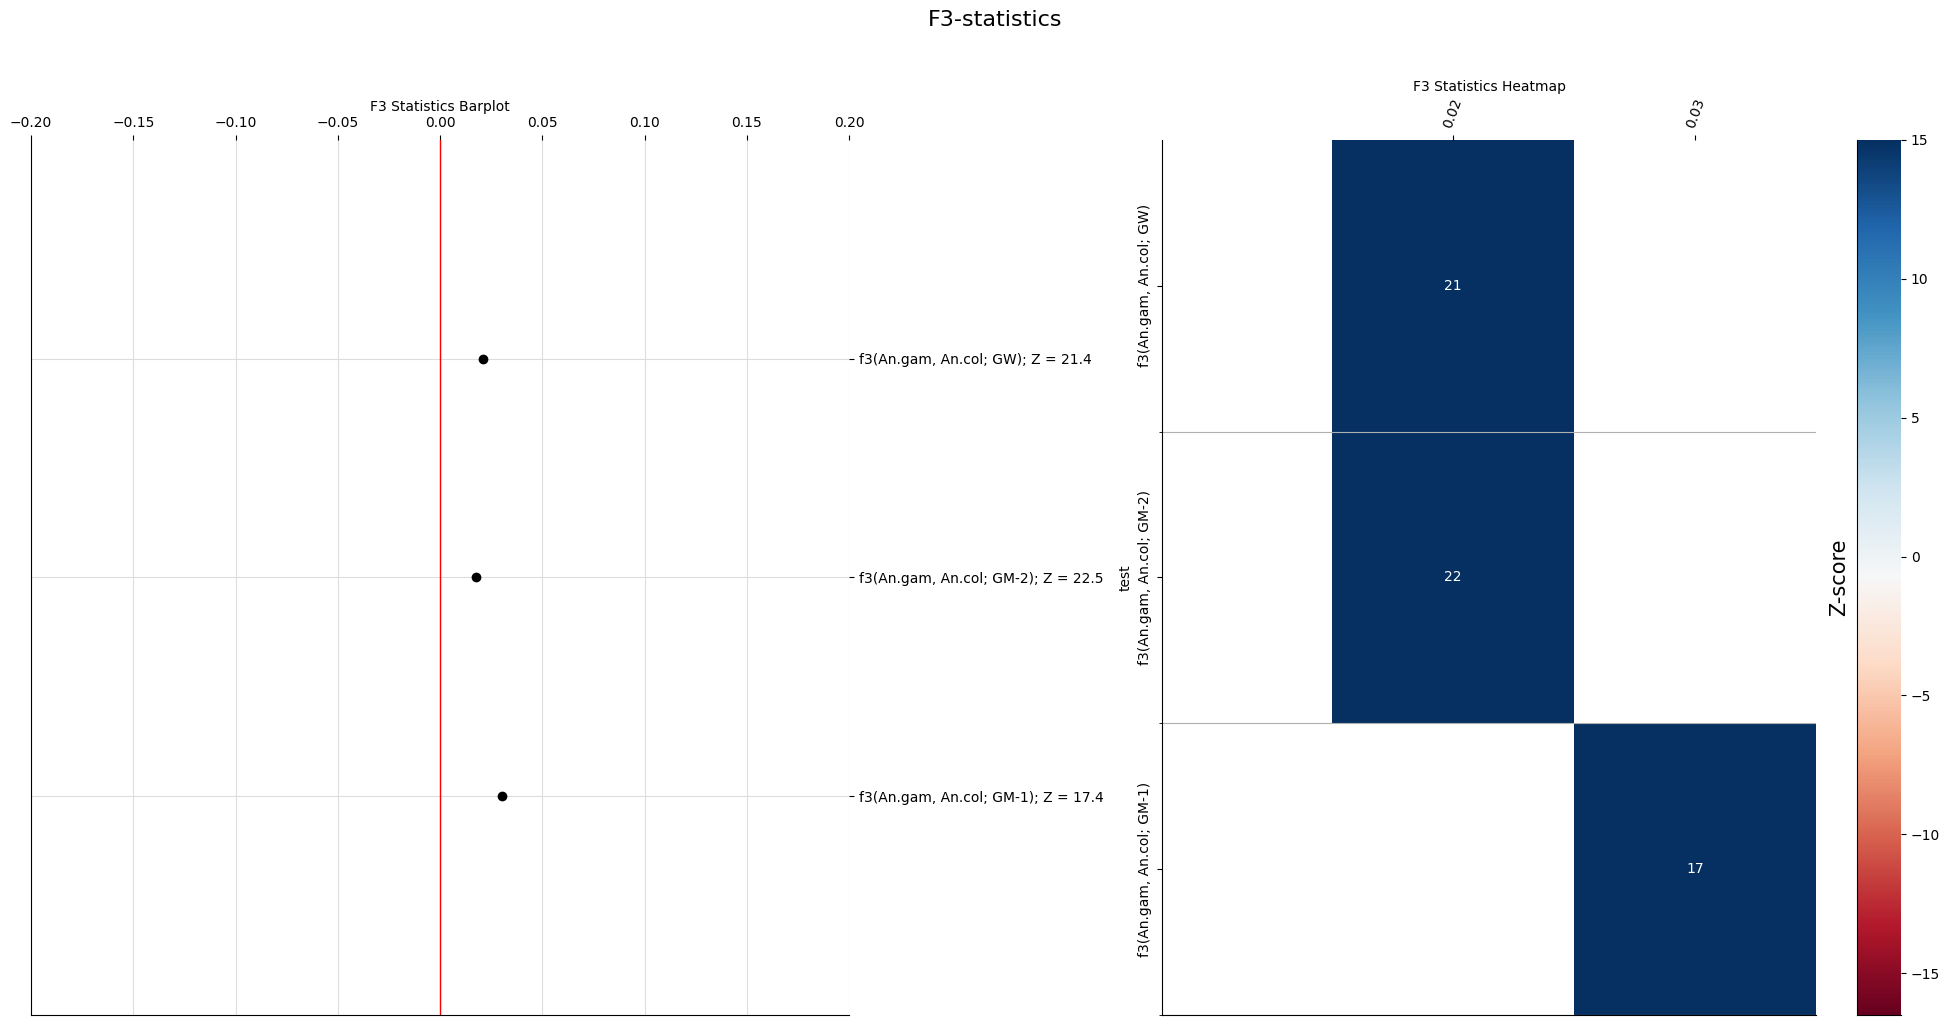

In [67]:
tbl_d_plot(f3_an, 'F3-statistics')

-------------------------------
## Fst

In [62]:
calldata_biallel= zarr.open('../Data/Extras/fw_biallelic_count_pca_pops.zarr/')

In [63]:
an_col = 'An.col'
an_gam = 'An.gam'
an_na = 'GM-1', 'GM-2', 'GW'

In [64]:
def f4_analysis(chroms, A, B, regions=None, blen=100000, plot=False, ax=None):
    
    
    
    region_str = ",".join(["{0}_{1}".format(r.start, r.stop) for r in regions])
    
    key = (",".join(chroms), region_str, A, B, blen)
    if key in fourpop_cache:
        # re-use from cache
        d, d_se, d_vb, d_vj = fourpop_cache[key]
        
    else:
        # load allele counts
        aca = dask.array.vstack([load_ac(chrom, A)[region] for chrom, region in zip(chroms, regions)])
        acb = dask.array.vstack([load_ac(chrom, B)[region] for chrom, region in zip(chroms, regions)])
            
        # run D test
        d, d_se, d_vb, d_vj = allel.average_hudson_fst(aca, acb, 
                                                                     blen=blen)
        
        # cache for re-use
        fourpop_cache[key] = d, d_se, d_vb, d_vj
    
    return d, d_se, d_vb, d_vj

def f4_analys(As, Bs, chroms=chromosomes, regions=None, blen=100000):
    
    if regions is None:
        regions = [slice(None)] * 4
    
    region_str = ",".join(["{0}_{1}".format(r.start, r.stop) for r in regions])
    # normalise inputs
    if not isinstance(chroms, (list, tuple)):
        chroms = [chroms]
    if not isinstance(As, (list, tuple)):
        As = [As]
    if not isinstance(Bs, (list, tuple)):
        Bs = [Bs]

    # setup output table
    tbl = [['chromosome', 'test', 'Fst', 'SE']]

    for A in As:
        for B in Bs:
            if A != B:
                            d, d_se, _, _ = f4_analysis(chroms, A, B,  
                                                             regions=regions, blen=blen)
                            test = 'Fst(%s, %s)' % (A, B)
                            row = [",".join(chroms), test, d, d_se]
                            tbl += [row]

    # display results
    (etl
     .wrap(tbl)
     .interpolate('Fst', '%.3f')
     .interpolate('SE', '%.4f')
     .displayall(index_header=False))

In [65]:
A = an_col
B = an_na

In [66]:
f4_analys(A, B, chroms=("3L", "3R"),
                regions=(slice(18_000_000, 41_000_000), slice(1, 24000000)))

chromosome,test,Fst,SE
"3L,3R","Fst(An.col, GM-1)",0.010,0.0006
"3L,3R","Fst(An.col, GM-2)",0.028,0.0014
"3L,3R","Fst(An.col, GW)",0.018,0.0012


In [67]:
A = an_gam
B = an_na

In [68]:
fst = f4_analys(A, B, chroms=("3L", "3R"),
                regions=(slice(18_000_000, 41_000_000), slice(1, 24000000)))

chromosome,test,Fst,SE
"3L,3R","Fst(An.gam, GM-1)",0.035,0.0018
"3L,3R","Fst(An.gam, GM-2)",0.032,0.0010
"3L,3R","Fst(An.gam, GW)",0.027,0.0012


In [69]:
A = an_na
B = an_na
fst = f4_analys(A, B, chroms=("3L", "3R"),
                regions=(slice(18_000_000, 41_000_000), slice(1, 24000000)))

chromosome,test,Fst,SE
"3L,3R","Fst(GM-1, GM-2)",0.020,0.0010
"3L,3R","Fst(GM-1, GW)",0.009,0.0007
"3L,3R","Fst(GM-2, GM-1)",0.020,0.0010
"3L,3R","Fst(GM-2, GW)",0.009,0.0002
"3L,3R","Fst(GW, GM-1)",0.009,0.0007
"3L,3R","Fst(GW, GM-2)",0.009,0.0002


In [70]:
A = an_gam
B = an_col
fst = f4_analys(A, B, chroms=("3L", "3R"),
                regions=(slice(18_000_000, 41_000_000), slice(1, 24000000)))

chromosome,test,Fst,SE
"3L,3R","Fst(An.gam, An.col)",0.033,0.0019


------------------------------
## Fst plot

In [2]:
fst = pd.read_csv('../Data/Meta/fst_pop.csv',names=['region','pop1','pop2','fst', 'se'], sep = '\t').drop(columns=["region"])
fst

,pop1,pop2,fst,se
0,An.col,GM-1,0.010,0.0006
1,GM-1,An.col,0.010,0.0006
2,An.col,GM-2,0.028,0.0014
3,GM-2,An.col,0.028,0.0014
4,An.col,GW,0.018,0.0012
5,GW,An.col,0.018,0.0012
6,An.gam,GM-1,0.035,0.0018
7,GM-1,An.gam,0.035,0.0018
8,An.gam,GM-2,0.032,0.0010
9,GM-2,An.gam,0.032,0.0010


In [3]:
order = ['An.col', 'An.gam','GM-1', 'GM-2', 'GW']

In [4]:
#fst.fst = pd.to_numeric(fst['fst'], errors='coerce')
df = fst.pivot(index='pop1', columns='pop2', values='fst')[order]
df = df.fillna(df.T).loc[order]

In [5]:
df

pop2,An.col,An.gam,GM-1,GM-2,GW
pop1,,,,,
An.col,NaN,0.033,0.010,0.028,0.018
An.gam,0.033,NaN,0.035,0.032,0.027
GM-1,0.010,0.035,NaN,0.020,0.009
GM-2,0.028,0.032,0.020,NaN,0.009
GW,0.018,0.027,0.009,0.009,NaN


<AxesSubplot:xlabel='pop2', ylabel='pop1'>

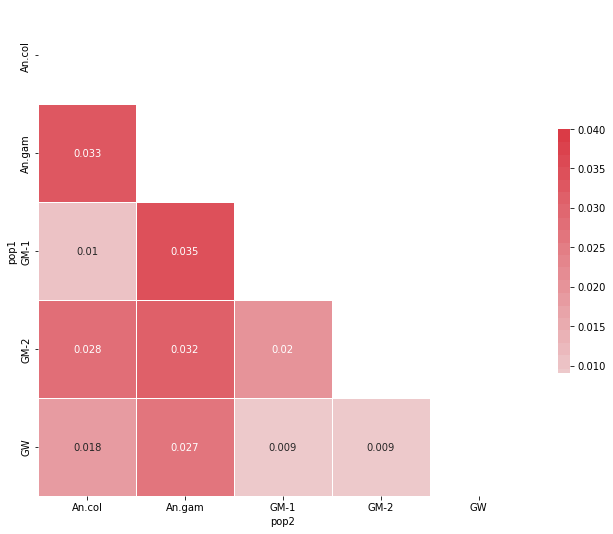

In [6]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, n=50)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df, mask=mask, cmap=cmap, vmax=.04, center=0,
            square=True, linewidths=.5,annot=True, cbar_kws={"shrink": .5})